In [25]:
import pandas as pd
import numpy as np
import traffic
from traffic.core import Traffic
from traffic.data import opensky
from traffic.data import airports
from traffic.data import aircraft
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm 
import importlib
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

In [3]:

from traffic.data import opensky, airports
# Zeitraum und Flughafen definieren - Variablen
start_time = "2019-11-01 09:00" # Format: year-month-day hour:minute
end_time = "2019-11-01 11:00" # Format: year-month-day hour:minute
airport_code = "LSZH"  # ICAO Airport code
 
# Flugdaten abrufen --> Daten werden im Cache gespeichert (180 Tage)
flights = opensky.history(
    start=start_time,
    stop=end_time,
    #return_flight=True,
    bounds=airports[airport_code].shape.convex_hull.buffer(0.05) # Radius in Breitengrad 5.55km und radius in längengrad 3.75 km => Dübendorf hat entfernung von 8km
)

flights

RUNNING: : 70.4% [00:21, 3.29%/s]
DOWNLOAD: 161klines [00:08, 18.9klines/s]


icao24 callsign  count
0  4b5d31    GALA2   7014
1  4b5c55   GALA56   6912
2  4b17fd  SWR299V   6103
3  4b5db0     RTT4   3151
4  4b5c1a   GUSTI2   2688
5  4b5c1d   ZEBRA1   2350
6  4b17ff  SWR205K   2258
7  4b1809  SWR115U   2219
8  4b1809  SWR105V   2140
9  4b5d9f   ALT777   2118

In [13]:
import numpy as np
import pandas as pd
# Function to correct format of timestamps
def convert_timestamp(x):
    if isinstance(x, (float, int)) and x > 1e9:  # Convert to unix timestamps if float or int.
        return pd.to_datetime(x, unit='s', errors='coerce')
    elif isinstance(x, pd.Timestamp): # If x is alreardy a pandas timestamp, x will be returned
        return x
    else:
        return pd.NaT  # Invalid Value will be converted to Not a Timestamp
    
flights.data
 
# Make sure data format is "correct"
flights.data['timestamp'] = flights.data['timestamp'].apply(convert_timestamp)
flights.data['hour'] = flights.data['hour'].apply(convert_timestamp)
flights.data['onground'] = flights.data['onground'].astype(np.bool_)
flights.data['alert'] = flights.data['alert'].astype(np.bool_)
flights.data['spi'] = flights.data['spi'].astype(np.bool_)
flights.data['last_position'] = flights.data['last_position'].astype(np.float64)
flights.data['icao24'] = flights.data['icao24'].astype('object')
flights.data['callsign'] = flights.data['callsign'].astype('object')
flights.data['squawk'] = flights.data['squawk'].astype('object')

flights.data.dtypes

timestamp        datetime64[ns, UTC]
icao24                        object
latitude                     float64
longitude                    float64
groundspeed                  float64
track                        float64
vertical_rate                float64
callsign                      object
onground                        bool
alert                           bool
spi                             bool
squawk                        object
altitude                     float64
geoaltitude                  float64
last_position                float64
serials                       object
hour             datetime64[ns, UTC]
dtype: object

In [14]:
max_workers=4
flights = flights.assign_id().resample('1s').eval(max_workers=max_workers, desc='resampling')
flights = flights.aircraft_data()
flights = flights.cumulative_distance().eval(max_workers=max_workers, desc='cumdist')
flights

resampling:   0%|          | 0/214 [00:00<?, ?it/s]

cumdist:   0%|          | 0/214 [00:00<?, ?it/s]

,count
flight_id,
GALA56_149,7194
GALA2_159,7101
SWR299V_089,5640
RTT4_178,3319
ZEBRA1_137,2762
GALA6_161,2395
ALT777_170,2354
SWR205K_090,2258
SWR115U_100,2149


## Trajs Preprocessing and Classification (Takeoff & Pushback)

In [33]:
airport_str = 'LSZH'

# May 2024
# trajs_filenames = ['LSZH_MAY24_1.pkl', 'LSZH_MAY24_2.pkl', 'LSZH_MAY24_3.pkl']
# start = ["2024-05-01 00:00","2024-05-11 00:00", "2024-05-21 00:00"]
# stop = ["2024-05-10 23:59","2024-05-20 23:59", "2024-05-31 23:59"]

# trajs_filenames = ['LSZH_MAY24_2.pkl', 'LSZH_MAY24_3.pkl']
# start = ["2024-05-11 00:00", "2024-05-21 00:00"]
# stop = ["2024-05-20 23:59", "2024-05-31 23:59"]

# # June 2024
# trajs_filenames = ['LSZH_JUN24_1.pkl', 'LSZH_JUN24_2.pkl', 'LSZH_JUN24_3.pkl']
# start = ["2024-06-01 00:00","2024-06-11 00:00", "2024-06-21 00:00"]
# stop = ["2024-06-10 23:59","2024-06-20 23:59", "2024-06-30 23:59"]

# # July 2024
# trajs_filenames = ['LSZH_JUL24_1.pkl', 'LSZH_JUL24_2.pkl', 'LSZH_JUL24_3.pkl']
# start = ["2024-07-01 00:00","2024-07-11 00:00", "2024-07-21 00:00"]
# stop = ["2024-07-10 23:59","2024-07-20 23:59", "2024-07-31 23:59"]

# # August 2024
# trajs_filenames = ['LSZH_AUG24_1.pkl', 'LSZH_AUG24_2.pkl', 'LSZH_AUG24_3.pkl']
# start = ["2024-08-01 00:00","2024-08-11 00:00", "2024-08-21 00:00"]
# stop = ["2024-08-10 23:59","2024-08-20 23:59", "2024-08-31 23:59"]

# # September 2024
# trajs_filenames = ['LSZH_SEP24_1.pkl', 'LSZH_SEP24_2.pkl', 'LSZH_SEP24_3.pkl']
# start = ["2024-09-01 00:00","2024-09-11 00:00", "2024-09-21 00:00"]
# stop = ["2024-09-10 23:59","2024-09-20 23:59", "2024-09-30 23:59"]


In [27]:
from agps_config import DF_MISSING_ICAO24

def add_known_missing_icao24(df_movements: pd.DataFrame):
    # Merge df_movements with missing icao24 df
    df_movements = df_movements.merge(DF_MISSING_ICAO24[['icao24', 'typecode', 'icaoaircrafttype']], 
                                    on='icao24', 
                                    how='left')

    df_movements['typecode_x'] = df_movements['typecode_x'].combine_first(df_movements['typecode_y'])
    # df_movements['icaoaircrafttype_x'] = df_movements['icaoaircrafttype_x'].combine_first(df_movements['icaoaircrafttype_y'])
    df_movements.loc[df_movements['icaoaircrafttype_y'].notna(), 'icaoaircrafttype_x'] = df_movements['icaoaircrafttype_y']
    df_movements.drop(columns=['typecode_y', 'icaoaircrafttype_y'], inplace=True)

    # Rename specific columns
    df_movements = df_movements.rename(columns={'typecode_x': 'typecode', 
                                                'icaoaircrafttype_x': 'icaoaircrafttype'})
    
    # Replace 'C68A' with 'L2J' in the 'icaoaircrafttype' column 
    df_movements.loc[df_movements['icaoaircrafttype'] == 'C68A', 'icaoaircrafttype'] = 'L2J'


    return df_movements

def remove_helos_and_noise(df_movements: pd.DataFrame) -> pd.DataFrame:

    # Filter out rows where 'icaoaircrafttype' contains 'H' anywhere in the string
    df_movements = df_movements[~df_movements['icaoaircrafttype'].str.contains('H', case=False, na=False)]

    # Filter out trajectories which have taxi distances of NaN
    df_movements = df_movements[~df_movements['taxiDistance'].isna()]

    # Filter out trajectories which have taxi distances of NaN
    df_movements = df_movements[~df_movements['lineupTime'].isna()]

    # Filter trajectories which have taxiDurations of less than 0
    df_movements =df_movements[~(df_movements['taxiDuration'] < pd.Timedelta(0))]

    return df_movements


def get_df_movements(gnd_trajs):

    # Group by 'flight_id'
    grouped = gnd_trajs.query('takeoffRunway != ""').groupby('flight_id')
    
    # Create a new DataFrame df_movements to store the summarized data
    df_movements = pd.DataFrame()
    
    # Extract the required information
    df_movements['flight_id'] = grouped['flight_id'].first()
    df_movements['icao24'] = grouped['icao24'].first()
    df_movements['callsign'] = grouped['callsign'].first()
    df_movements['isTakeoff'] = grouped['isTakeoff'].first()
    df_movements['isPushback'] = grouped['isPushback'].first()
    df_movements['startPushback'] = grouped['startPushback'].first()
    df_movements['startTaxi'] = grouped['startTaxi'].first()
    df_movements['lineupTime'] = grouped['lineupTime'].first()
    df_movements['taxiDuration'] = grouped['taxiDuration'].first()
    df_movements['taxiDistance'] = grouped['taxiDistance'].first()
    df_movements['takeoffRunway'] = grouped['takeoffRunway'].first()
    df_movements['typecode'] = grouped['typecode'].first()
    df_movements['icaoaircrafttype'] = grouped['icaoaircrafttype'].first()
    
    # Reset index to get a clean DataFrame
    df_movements = df_movements.reset_index(drop=True)


    df_movements = add_known_missing_icao24(df_movements)
    df_movements = remove_helos_and_noise(df_movements)

    return df_movements

    

In [ ]:
from agps_funs import alternative_pushback_detection, takeoff_detection
from agps_config import get_Stands_LSZH
from traffic.data import aircraft

# Specify the available number of CPUs for computation
max_workers=8

i = 0
while i < len(trajs_filenames):
    print(trajs_filenames[i])
    
    # Download data from the OSN
    timestamps = pd.date_range(start[i], stop[i], freq="4h")
    data = []
    for t1, t2 in tqdm(zip(timestamps[:-1], timestamps[1:]), total=len(timestamps) - 1, desc="Processing timestamps"):
            tmp = opensky.history(start=str(t1), stop=str(t2), bounds=airports[airport_str].shape.convex_hull.buffer(0.1))
            if tmp is not None:
                data.append(tmp.data)
            
    gnd_trajs = pd.concat(data)
    
    # Make sure data format is "correct"
    gnd_trajs['timestamp'] = pd.to_datetime(gnd_trajs['timestamp'], errors='coerce', utc=True)
    gnd_trajs['hour'] = pd.to_datetime(gnd_trajs['hour'], errors='coerce', utc=True)
    gnd_trajs['onground'] = gnd_trajs['onground'].astype(np.bool_)
    gnd_trajs['alert'] = gnd_trajs['alert'].astype(np.bool_)
    gnd_trajs['spi'] = gnd_trajs['spi'].astype(np.bool_)
    gnd_trajs['last_position'] = gnd_trajs['last_position'].astype(np.float64)

    # Retain only points near the ground or on the ground
    gnd_trajs = gnd_trajs.query('altitude<4000 or onground')
    gnd_trajs = Traffic(gnd_trajs)

    # Resample & add additional columns
    gnd_trajs = gnd_trajs.assign_id().resample('1s').eval(max_workers=max_workers, desc='resampling')
    gnd_trajs = gnd_trajs.aircraft_data()
    gnd_trajs = gnd_trajs.cumulative_distance().eval(max_workers=max_workers, desc='cumdist')

    # Get icaoaircrafttype (if there is any)
    aircraftdata=aircraft.data
    aircraftdata['icao24'] = aircraftdata['icao24'].str.strip().str.lower()
    gnd_trajs = gnd_trajs.merge(aircraftdata[['icao24', 'icaoaircrafttype']], 
                                on='icao24', 
                                how='left')

    # Classify takeoffs
    gnd_trajs = gnd_trajs.iterate_lazy().pipe(takeoff_detection, 'lszh').eval(max_workers=max_workers, desc='Takeoff Detection')

    # Classify pushbacks
    stands = get_Stands_LSZH()
    gnd_trajs = gnd_trajs.iterate_lazy().pipe(alternative_pushback_detection, stands).eval(max_workers=max_workers, desc='Pushback Detection')

    # Save traj data
    gnd_trajs.to_pickle(trajs_filenames[i])

    # Get df_movements & save
    df_movements = get_df_movements(gnd_trajs)
    save_filename = trajs_filenames[i].replace('.pkl', '_df_movements.pkl')
    df_movements.to_pickle(save_filename)

    i +=1


***
# Fuel Estimation
***

In [96]:
import agps_funs
from agps_config import AC2CONSIDER
importlib.reload(agps_funs)

# Concatinate df_movements of multiple months
file_paths = ['LSZH_MAY24_1_df_movements.pkl', 'LSZH_MAY24_2_df_movements.pkl', 'LSZH_MAY24_3_df_movements.pkl',
              'LSZH_JUN24_1_df_movements.pkl', 'LSZH_JUN24_2_df_movements.pkl', 'LSZH_JUN24_3_df_movements.pkl',
              'LSZH_JUL24_1_df_movements.pkl', 'LSZH_JUL24_2_df_movements.pkl', 'LSZH_JUL24_3_df_movements.pkl',
              'LSZH_AUG24_1_df_movements.pkl', 'LSZH_AUG24_2_df_movements.pkl', 'LSZH_AUG24_3_df_movements.pkl',
              'LSZH_SEP24_1_df_movements.pkl', 'LSZH_SEP24_2_df_movements.pkl', 'LSZH_SEP24_3_df_movements.pkl',
              ]


df_list = [pd.read_pickle(file) for file in file_paths]
df_movements = pd.concat(df_list, ignore_index=True).convert_dtypes()

df_movements = df_movements.query('isTakeoff')
df_movements = df_movements[df_movements['typecode'].isin(AC2CONSIDER)]

# Get some aircraft-related data
df_movements = agps_funs.getNengine_df(df_movements)
df_movements = agps_funs.getIdleFF_df(df_movements)
df_movements = agps_funs.getAPUfuelFlow_df(df_movements)

# Estimate Fuel Consumption for Normal Taxi & external AGPS
df_movements = agps_funs.normalTaxiFuel_df(df_movements)
df_movements = agps_funs.extAGPSTaxiFuel_df(df_movements)

df_movements = agps_funs.normalTaxiFuel_df(df_movements, 
                                           startupTime=60,
                                           warmupTime=180,
                                           colNames=['MESengine180', 'MESapu180', 'normTAXIengine180']
                                           )

df_movements.to_pickle('LSZH_MAY_SEP_df_movements.pkl')
df_movements

/var/folders/84/0lntlwrj46zgpwppnsr6znzw0000gr/T/ipykernel_14605/681712110.py:17: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  df_movements = df_movements.query('isTakeoff')


,flight_id,icao24,callsign,isTakeoff,isPushback,startPushback,startTaxi,lineupTime,taxiDuration,taxiDistance,...,APUhighFF,APUnormalFF,MESengine,MESapu,normTAXIengine,extAGPSapu,extAGPStug,MESengine180,MESapu180,normTAXIengine180
2,AAL93_11938,aae1ea,AAL93,True,False,NaT,2024-05-05 09:48:15+00:00,2024-05-05 10:04:55+00:00,0 days 00:16:40,1.356054,...,262,238,93.66,16.666667,446.000,66.111111,NaN,120.42,20.633333,446.000
3,AAL93_11941,aae597,AAL93,True,False,NaT,2024-05-01 09:51:09+00:00,2024-05-01 10:03:06+00:00,0 days 00:11:57,1.354637,...,262,238,93.66,16.666667,319.782,47.401667,NaN,120.42,20.633333,319.782
4,AAL93_11945,ab1839,AAL93,True,False,NaT,2024-05-09 10:01:50+00:00,2024-05-09 10:19:47+00:00,0 days 00:17:57,1.112419,...,262,238,93.66,16.666667,480.342,71.201667,NaN,120.42,20.633333,480.342
5,AAL93_11947,ab1fa7,AAL93,True,True,2024-05-03 09:43:46+00:00,2024-05-03 09:44:57+00:00,2024-05-03 09:56:52+00:00,0 days 00:11:55,0.426034,...,262,238,93.66,16.666667,318.890,47.269444,NaN,120.42,20.633333,318.890
6,AAL93_11950,ab236a,AAL93,True,False,NaT,2024-05-04 09:41:23+00:00,2024-05-04 09:52:56+00:00,0 days 00:11:33,0.788887,...,262,238,93.66,16.666667,309.078,45.815000,NaN,120.42,20.633333,309.078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57567,VLG7516_174,344099,VLG7516,True,False,NaT,2024-09-27 12:52:06+00:00,2024-09-27 12:55:13+00:00,0 days 00:03:07,0.322391,...,130,110,44.94,8.000000,40.018,5.713889,NaN,57.78,9.833333,40.018
57568,VLG7516_222,344697,VLG7516,True,False,NaT,2024-09-30 08:53:26+00:00,2024-09-30 08:55:29+00:00,0 days 00:02:03,0.386516,...,130,110,44.94,8.000000,26.322,3.758333,NaN,57.78,9.833333,26.322
57569,VLG7516_247,345645,VLG7516,True,False,NaT,2024-09-23 08:40:30+00:00,2024-09-23 08:46:04+00:00,0 days 00:05:34,0.922098,...,130,110,44.94,8.000000,71.476,10.205556,NaN,57.78,9.833333,71.476
57570,VLG7516_270,346090,VLG7516,True,False,NaT,2024-09-25 12:47:27+00:00,2024-09-25 12:52:50+00:00,0 days 00:05:23,0.34366,...,130,110,33.60,8.000000,51.680,9.869444,NaN,43.20,9.833333,51.680


In [95]:
df_movements

,flight_id,icao24,callsign,isTakeoff,isPushback,startPushback,startTaxi,lineupTime,taxiDuration,taxiDistance,...,APUhighFF,APUnormalFF,MESengine,MESapu,normTAXIengine,extAGPSapu,extAGPStug,MESengine180,MESapu180,normTAXIengine180
2,AAL93_11938,aae1ea,AAL93,True,False,NaT,2024-05-05 09:48:15+00:00,2024-05-05 10:04:55+00:00,0 days 00:16:40,1.356054,...,262,238,93.66,16.666667,446.000,66.111111,NaN,120.42,20.633333,446.000
3,AAL93_11941,aae597,AAL93,True,False,NaT,2024-05-01 09:51:09+00:00,2024-05-01 10:03:06+00:00,0 days 00:11:57,1.354637,...,262,238,93.66,16.666667,319.782,47.401667,NaN,120.42,20.633333,319.782
4,AAL93_11945,ab1839,AAL93,True,False,NaT,2024-05-09 10:01:50+00:00,2024-05-09 10:19:47+00:00,0 days 00:17:57,1.112419,...,262,238,93.66,16.666667,480.342,71.201667,NaN,120.42,20.633333,480.342
5,AAL93_11947,ab1fa7,AAL93,True,True,2024-05-03 09:43:46+00:00,2024-05-03 09:44:57+00:00,2024-05-03 09:56:52+00:00,0 days 00:11:55,0.426034,...,262,238,93.66,16.666667,318.890,47.269444,NaN,120.42,20.633333,318.890
6,AAL93_11950,ab236a,AAL93,True,False,NaT,2024-05-04 09:41:23+00:00,2024-05-04 09:52:56+00:00,0 days 00:11:33,0.788887,...,262,238,93.66,16.666667,309.078,45.815000,NaN,120.42,20.633333,309.078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57567,VLG7516_174,344099,VLG7516,True,False,NaT,2024-09-27 12:52:06+00:00,2024-09-27 12:55:13+00:00,0 days 00:03:07,0.322391,...,130,110,44.94,8.000000,40.018,5.713889,NaN,57.78,9.833333,40.018
57568,VLG7516_222,344697,VLG7516,True,False,NaT,2024-09-30 08:53:26+00:00,2024-09-30 08:55:29+00:00,0 days 00:02:03,0.386516,...,130,110,44.94,8.000000,26.322,3.758333,NaN,57.78,9.833333,26.322
57569,VLG7516_247,345645,VLG7516,True,False,NaT,2024-09-23 08:40:30+00:00,2024-09-23 08:46:04+00:00,0 days 00:05:34,0.922098,...,130,110,44.94,8.000000,71.476,10.205556,NaN,57.78,9.833333,71.476
57570,VLG7516_270,346090,VLG7516,True,False,NaT,2024-09-25 12:47:27+00:00,2024-09-25 12:52:50+00:00,0 days 00:05:23,0.34366,...,130,110,33.60,8.000000,51.680,9.869444,NaN,43.20,9.833333,51.680


***
# Some stats
***

In [22]:
# Group by TO_runway and calculate mean and std
# overview = df_movements.groupby('takeoffRunway')['taxiDuration'].agg(['count', 'mean', 'std']).reset_index()
overview = df_movements.groupby('takeoffRunway')['takeoffRunway'].agg(['count']).reset_index()


# # # Add May 2024 data
# overview['count_FZAG_MAY'] = [173, 0,  1014, 7251, 3140, 156]

# # Add June 2024 data
# overview['count_FZAG_JUN'] = [236, 0, 1151,	7309, 2826,	155]

# # Add July 2024 data
# overview['count_FZAG_JUL'] = [29, 0, 1497,	6841, 3594,	144]

# # Add August 2024 data
# overview['count_FZAG_AUG'] = [296, 0, 1365,	7341, 2772,	144]

# # Add MAY to AUG data
# overview['count_FZAG'] = [734, 0,  5027, 28742, 12332, 599]

overview['Error'] = (overview['count']-overview['FZAG'])/overview['FZAG']*100

# Display the result
overview

# Total Error over all movements
(overview['count'].sum()-overview['FZAG'].sum())/overview['FZAG'].sum()*100

,takeoffRunway,count,count_FZAG_MAY,count_FZAG_JUN,FZAG,Error
0,10,444,173,236,409,8.557457
1,14,2,0,0,0,inf
2,16,1997,1014,1151,2165,-7.759815
3,28,13886,7251,7309,14560,-4.629121
4,32,5709,3140,2826,5966,-4.307744
5,34,289,156,155,311,-7.073955


In [319]:
# Group by 'takeoffRunway' and count the total occurrences of 'taxiDuration' per group
overview = df_movements.groupby('takeoffRunway')['taxiDuration'].agg(['count']).reset_index()

# Iterate over each unique value in 'icaoaircrafttype' and add a column for each, counting occurrences
for icao_type in df_movements['icaoaircrafttype'].unique():
    overview[icao_type] = df_movements.groupby('takeoffRunway')['icaoaircrafttype'].apply(lambda x: (x == icao_type).sum()).values

# Add May data
overview['count_FZAG'] = [173, 0,  1014, 7251, 3140, 156]

overview

,takeoffRunway,count,L2J,NaN,L1T,L3J,L2T,L4J,L1P,L2P,,L1J,count_FZAG
0,10,188,174,0,0,0,1,3,1,1,1,0,173
1,14,1,1,0,0,0,0,0,0,0,0,0,0
2,16,910,790,0,0,0,0,112,1,4,0,0,1014
3,28,6791,6300,0,50,40,63,13,29,18,20,3,7251
4,32,3027,2839,0,11,12,21,69,4,4,0,1,3140
5,34,144,106,0,0,1,0,36,0,0,0,0,156


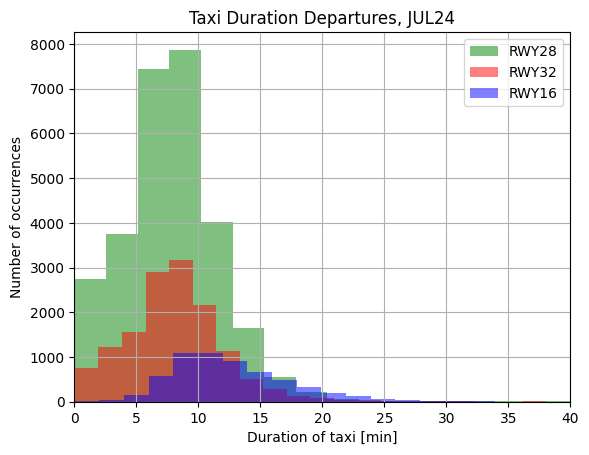

In [89]:
import matplotlib.pyplot as plt

# Plotting histograms
plt.hist((df_movements.query('takeoffRunway=="28"').taxiDuration.dt.total_seconds()/60), 
         bins=50, color='g', alpha=0.5, label='RWY28')
plt.hist((df_movements.query('takeoffRunway=="32"').taxiDuration.dt.total_seconds()/60), 
         bins=50, color='r', alpha=0.5, label='RWY32')
plt.hist((df_movements.query('takeoffRunway=="16"').taxiDuration.dt.total_seconds()/60), 
         bins=50, color='b', alpha=0.5, label='RWY16')

# Adding grid, legend, labels, and title
plt.xlim((0,40))
plt.grid()
plt.legend(loc='upper right')
plt.xlabel("Duration of taxi [min]")
plt.ylabel('Number of occurrences')
plt.title('Taxi Duration Departures')

# Display the plot
plt.show()
